Now that we've prepped the data, let's build a model to predict delivery duration.

We will experiment with various regression algorithms. For each algorithm, we will tune relevant hyperparameters to maximize algorithm performance. Then, we will compare performance across models.

We will build models using the following regression algorithms:
- Linear (Lasso) Regression
- Support Vector Regression
- Random Forest Regression
- Gradient Boosted Regression

We will evaluate these models on Root Mean Squared Error (RMSE), as that will allow us to express the errors of the predictions in seconds.


Load cleaned train data.

In [43]:
# ensures notebook automatically receives updates from .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import os
import numpy as np

data_path = '../datasets/clean/train_data.csv'

df = pd.read_csv(data_path)
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,seconds_to_delivery,store_id_freq,store_category_type,item_price_range,hour_of_day
0,2.0,2015-02-17 22:10:38+00:00,2015-02-17 22:40:27+00:00,2963,american,1.0,3,1054,3,0,...,15.0,14.0,15.0,446,342.0,1789.0,[90-99),american,679,22
1,4.0,2015-02-16 03:02:02+00:00,2015-02-16 03:50:19+00:00,1229,korean,2.0,2,3748,2,1499,...,109.0,102.0,181.0,251,1012.0,2897.0,[90-99),asian,750,3
2,2.0,2015-01-25 23:24:42+00:00,2015-01-25 23:59:07+00:00,6770,pizza,3.0,2,1998,1,599,...,28.0,53.0,46.0,251,589.0,2065.0,[75-90),italian,0,23
3,5.0,2015-02-14 03:42:33+00:00,2015-02-14 04:43:18+00:00,15,mexican,3.0,1,995,1,995,...,25.0,25.0,46.0,251,760.0,3645.0,[75-90),mexican,0,3
4,2.0,2015-02-01 23:06:51+00:00,2015-02-01 23:38:44+00:00,5700,sandwich,3.0,2,1097,2,399,...,58.0,61.0,64.0,251,473.0,1913.0,[90-99),american,80,23


Establish numeric vs. categorical features, & separate features from target

In [17]:
numeric_feats = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration',
    'item_price_range',
    'hour_of_day',
]

categorical_feats = [
    'market_id',
    'order_protocol',
    'store_id_freq',
    'store_category_type',
]

target = 'seconds_to_delivery'

In [18]:
df_X = df[numeric_feats + categorical_feats]

df_y = df[target]

assert len(df_X)==len(df_y)

In [19]:
df_X.head()

,total_items,subtotal,num_distinct_items,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,item_price_range,hour_of_day,market_id,order_protocol,store_id_freq,store_category_type
0,3,1054,3,15.0,14.0,15.0,446,342.0,679,22,2.0,1.0,[90-99),american
1,2,3748,2,109.0,102.0,181.0,251,1012.0,750,3,4.0,2.0,[90-99),asian
2,2,1998,1,28.0,53.0,46.0,251,589.0,0,23,2.0,3.0,[75-90),italian
3,1,995,1,25.0,25.0,46.0,251,760.0,0,3,5.0,3.0,[75-90),mexican
4,2,1097,2,58.0,61.0,64.0,251,473.0,80,23,2.0,3.0,[90-99),american


In [20]:
df_y.head()

0    1789.0
1    2897.0
2    2065.0
3    3645.0
4    1913.0
Name: seconds_to_delivery, dtype: float64

**Defining Preprocessing Pipelines**

Now, we'll define the transformers we want to include in our preprocessing pipeline.

Scikit-learn includes many transformers out of the box that you may include in a Pipeline object to automate the preprocessing workflow prior to model prediction. Additionally, you may define your own custom transformer to apply on your data, if scikit-learn does not provide it. 

For our data, we will define a custom transformer to drop highly correlated features in our data prior to passing it to our model for prediction. 
- It is a stateful transformation (i.e. it must learn the correlations among our feature space prior to the transformation).
- So, we must implement fit() & transform() methods.

For more information about defining custom data transformers, check out the links at the bottom of the notebook.

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

In [22]:
import sys
sys.path.append('../utils')
import custom_transformers
from custom_transformers import DropHighlyCorrelatedFeatures # custom transformer to drop highly correlated features prior to model prediction

The regression algorithms we will experiment with will require all or a subset of the following preprocessing steps leading up to prediction:
- Imputing missing feature values
- Scaling feature set (for Lasso & SVR only)
- Dropping highly correlated features
- One-hot encoding categorical features 

Lasso Regression & Support Vector Regression algorithms are sensitive to scaling since they involve distance-based computations, whereas Random Forest & Gradient Boosted Trees are built on top of Decision Trees, which involve threshold based splitting. 
- So, the pipeline for Lasso & SVR will require scaling the feature space. 
- Thus, we'll define two preprocessing pipelines, one with scaling and one without.

Note that we already took care of some of these preprocessing steps manually in our data preparation. However, defining this pipeline will come in handy when we want to apply this workflow to new data, as these steps will already be saved as part of our model artifact. 

In [23]:
# sequence of transformations to apply to categorical features
categorical_pipeline = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False)),
    ]
)

# sequence of transformations to apply to numeric features
numeric_pipeline_scaled = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler()),
        ("drop_correlated_feats", DropHighlyCorrelatedFeatures()),
    ]
)

numeric_pipeline = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="median")), 
        ("drop_correlated_feats", DropHighlyCorrelatedFeatures()),
    ]
)

# combine numeric & categorical feature transformations into single ColumnTransformer() object
preprocessor_w_scaling = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline_scaled, numeric_feats),
        ('cat', categorical_pipeline, categorical_feats),
    ],
)

preprocessor_wo_scaling = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numeric_feats),
        ('cat', categorical_pipeline, categorical_feats),
    ]
)

**Linear Regression**

Models linear relationship between a scalar target and one or more explanatory variables. Lasso regularization adds a penalty term to linear regression objective function that may zero out coefficients for features with little to no relationship with the prediction target.

Preprocessing requirements:
- Scaling (fair regularization requires features to be on similar scales, and scaling may speed up the linear regression optimization process)
- One-hot encoding for categorical features

Relevant hyperparameters:
- alpha: controls regularization strength, where larger values indicate stronger regularization

Scikit-learn APIs:
- https://scikit-learn.org/1.6/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
- https://scikit-learn.org/1.6/modules/generated/sklearn.model_selection.GridSearchCV.html#

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor_w_scaling), 
        ("regression", Lasso(random_state=13)),
    ]
)

lasso_param_grid = {
    "regression__alpha": np.logspace(-3, -2, 10),
}

lasso_search_cv = GridSearchCV(lasso_reg, lasso_param_grid, scoring='neg_root_mean_squared_error', verbose=4)

In [ ]:
lasso_search_cv.fit(df_X, df_y)

In [26]:
lasso_cv_results_df = pd.DataFrame(lasso_search_cv.cv_results_)

lasso_cv_results_df.sort_values(by='mean_test_score', ascending=False).drop(columns=['params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression__alpha,mean_test_score,std_test_score,rank_test_score
9,19.856981,2.214817,0.119525,0.015137,0.010000,-1080.421798,30.231262,1
8,19.789128,2.547866,0.132451,0.005560,0.007743,-1080.422253,30.231207,2
7,26.580545,4.298250,0.129238,0.020896,0.005995,-1080.422633,30.231133,3
6,23.344698,3.376484,0.123985,0.006741,0.004642,-1080.422885,30.231062,4
5,25.871059,2.859284,0.136542,0.016378,0.003594,-1080.423208,30.231025,5
4,29.386101,5.593429,0.127853,0.008373,0.002783,-1080.423468,30.230995,6
3,24.773890,2.511777,0.132348,0.005810,0.002154,-1080.423675,30.230969,7
2,28.924668,3.056647,0.122591,0.032291,0.001668,-1080.423838,30.230948,8
1,23.363257,4.356095,0.124623,0.009060,0.001292,-1080.423967,30.230931,9
0,18.701822,6.138398,0.094549,0.029439,0.001000,-1080.424068,30.230918,10


In [27]:
# Get the score of the best performing model & its alpha value
print("Best Score:", lasso_search_cv.best_score_)
print("Best Parameters:", lasso_search_cv.best_params_)

Best Score: -1080.4217982441126
Best Parameters: {'regression__alpha': np.float64(0.01)}


Lasso regression results:
- Best performing model had a root mean squared error of ~1080 seconds, or ~18 minutes. However, all models across different values of alpha had nearly identical performance. 
- On average, our predictions for delivery duration are ~18 minutes off from the true delivery duration. So, not super effective for predicting delivery duration.

**Support Vector Regression**

Regression algorithm derived from Support Vector Machines (https://scikit-learn.org/stable/modules/svm.html).

Preprocessing requirements:
- Scaling (SVR computes dot products between observations in the feature space, so certain features may dominate the dot product computations if they are on widely different scales)
- One-hot encoding for categorical features

Relevant hyperparameters:
- C: regularization parameter
- epsilon: error-budget (non-negative)
- kernel: linear, poly, rbf -> The relationship between the features & target doesn't seem to be appropriately described by a linear relationship. Additionally, fitting the RBF kernel was taking extremely long, so we'll proceed with a polynomial kernel.

Scikit-learn APIs:
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor_w_scaling),
        ("regression", SVR(kernel='poly', max_iter=1000)), 
    ]
)

svr_param_grid = {
    "regression__C": np.logspace(-3, 1, 4),
    'regression__epsilon': np.logspace(-3, 1, 4),
    # # 'regression__kernel': ['linear', 'poly', 'rbf']

}

svr_search_cv = GridSearchCV(svr_reg, svr_param_grid, verbose=4, scoring='neg_root_mean_squared_error')

In [ ]:
svr_search_cv.fit(df_X, df_y)

In [30]:
svr_cv_results_df = pd.DataFrame(svr_search_cv.cv_results_)

svr_cv_results_df.sort_values("mean_test_score", ascending=False).drop(columns=['params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression__C,param_regression__epsilon,mean_test_score,std_test_score,rank_test_score
6,9.664221,0.173374,1.374567,0.055117,0.021544,0.464159,-1335.926884,32.070325,1
4,10.401234,0.455546,1.521276,0.205808,0.021544,0.001000,-1335.927035,32.070505,2
5,9.612127,0.153293,1.395525,0.046941,0.021544,0.021544,-1335.927035,32.070505,2
7,10.057626,0.261788,1.459500,0.064989,0.021544,10.000000,-1336.054941,32.033936,4
1,23.964360,0.165073,3.606214,0.615819,0.001000,0.021544,-1336.430851,31.995590,5
0,23.455701,0.643504,3.920583,0.165312,0.001000,0.001000,-1336.430851,31.995590,5
2,13.245808,2.374624,2.253378,0.903757,0.001000,0.464159,-1336.430851,31.995590,7
3,12.947139,1.691789,1.903838,0.381740,0.001000,10.000000,-1336.431349,31.995209,8
10,9.941057,0.100923,1.487249,0.073854,0.464159,0.464159,-1486.448047,279.117572,9
8,9.824838,0.350721,1.469014,0.041215,0.464159,0.001000,-1486.465942,279.112962,10


In [31]:
print("Best score:", svr_search_cv.best_score_)
print("Best params:", svr_search_cv.best_params_)

Best score: -1335.926883563665
Best params: {'regression__C': np.float64(0.021544346900318832), 'regression__epsilon': np.float64(0.46415888336127775)}


SVR results:
- Best performing model had a root mean squared error of ~1335 seconds, or ~22 minutes.
- This is about 4 minutes worse than our best Lasso Regression model.
- Tuning the epsilon parameter (error budget) had nearly 0 impact on performance. However, weaker regularization (param_regression__C) negatively impacted model performance. 

**Random Forest Regression**

Ensemble method that combines the predictions of multiple decision trees, where each tree is built from a bootstrap sample drawn from the training set.

Preprocessing requirements:
- One-hot encode categorical features (not technically required)

Relevant hyperparamaters:
- n_estimators: # of trees in ensemble
- max_depth: limit tree complexity (how far each tree should be split)
- max_features: # of features to consider at each node split (lower value means trees are less correlated)

Scikit-learn APIs:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rfr_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor_wo_scaling), 
        ("regressor", RandomForestRegressor(random_state=13))
    ]
)

rfr_param_grid = {
    "regressor__n_estimators": [10, 100, 200],
    # 'regressor__max_depth': [None, 50],
    'regressor__max_features': ['sqrt', 'log2', None],
}

rfr_search_cv = GridSearchCV(rfr_clf, rfr_param_grid, verbose=4, scoring='neg_root_mean_squared_error')

In [ ]:
rfr_search_cv.fit(df_X, df_y)

In [34]:
rfr_cv_results = pd.DataFrame(rfr_search_cv.cv_results_)
rfr_cv_results = rfr_cv_results.sort_values("mean_test_score", ascending=False).drop(columns=['params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'])
rfr_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_features,param_regressor__n_estimators,mean_test_score,std_test_score,rank_test_score
5,88.732248,4.256260,4.498945,0.132426,log2,200,-1049.517021,30.309714,1
2,47.914489,0.523497,2.291023,0.045759,sqrt,200,-1049.600568,30.367691,2
4,24.547280,4.454571,1.452601,0.282438,log2,100,-1052.371489,30.212661,3
1,24.030757,0.498581,1.247704,0.080938,sqrt,100,-1052.543702,30.243942,4
8,420.705924,5.275555,4.731429,0.056524,None,200,-1068.528854,26.866791,5
7,212.509280,1.107555,2.450465,0.036316,None,100,-1071.614566,26.550061,6
3,2.278628,0.086512,0.176639,0.029473,log2,10,-1099.737394,28.910343,7
0,2.710949,0.116275,0.161595,0.012457,sqrt,10,-1102.077337,29.032308,8
6,22.083551,0.290809,0.336150,0.010065,None,10,-1120.108579,24.608533,9


In [35]:
print("Best score:", rfr_search_cv.best_score_)
print("Best params:", rfr_search_cv.best_params_)

Best score: -1049.5170207071897
Best params: {'regressor__max_features': 'log2', 'regressor__n_estimators': 200}


RFR results:
- Best performing model had a root mean squared error of ~1050 seconds (~17.5 minutes).
- Higher decorrelation among base estimators (param_regressor__max_features) resulted in better model performance, irrespective of number of estimators involved.
- So far, this is our best performing model, but not by much (errors are ~30 seconds lower than that of Lasso Regression).

**Gradient Boosted Regression**

Ensemble method that iteratively fits many weak learners in sequence, where each learner attempts to correct the errors of the previous. As opposed to random forest regression, the learners in gradient boosted regression are not independent.

Preprocessing requirements:
- One-hot encode categorical features (not technically required)

Relevant hyperparameters:
- learning_rate: dictates how much each individual learner contributes to final prediction 
- n_estimators: # of learners to include in ensemble

Scikit-learn APIs:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

gbr_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor_wo_scaling), 
        ("regressor", GradientBoostingRegressor(random_state=13))
    ]
)

gbr_param_grid = {
    "regressor__n_estimators": [10, 100, 200],
    'regressor__learning_rate': np.logspace(-3, 0, 4),
}

gbr_search_cv = GridSearchCV(gbr_clf, gbr_param_grid, verbose=4, scoring='neg_root_mean_squared_error')

In [ ]:
gbr_search_cv.fit(df_X, df_y)

In [38]:
gbr_cv_results = pd.DataFrame(gbr_search_cv.cv_results_)
gbr_cv_results = gbr_cv_results.sort_values("mean_test_score", ascending=False).drop(columns=['params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'])
gbr_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__n_estimators,mean_test_score,std_test_score,rank_test_score
8,82.697965,0.732269,0.266115,0.018268,0.100,200,-1046.317871,30.375405,1
7,41.944485,1.204494,0.173177,0.012902,0.100,100,-1052.587940,31.119862,2
10,42.018806,0.831958,0.163385,0.012175,1.000,100,-1055.328669,24.920510,3
11,83.474348,1.678366,0.222026,0.010757,1.000,200,-1062.160108,25.026698,4
9,4.640410,0.055426,0.106112,0.017491,1.000,10,-1062.575004,30.339912,5
5,81.371165,3.351004,0.309590,0.012831,0.010,200,-1083.627139,31.384947,6
6,5.131966,0.323323,0.109805,0.001289,0.100,10,-1102.672371,31.257071,7
4,41.838949,1.182333,0.205603,0.021186,0.010,100,-1103.806387,31.095903,8
2,83.614889,1.752438,0.355836,0.025337,0.001,200,-1141.503328,30.243615,9
3,4.691835,0.123246,0.104713,0.007916,0.010,10,-1149.762269,30.028332,10


In [39]:
print("Best score:", gbr_search_cv.best_score_)
print("Best params:", gbr_search_cv.best_params_)

Best score: -1046.3178705153373
Best params: {'regressor__learning_rate': np.float64(0.1), 'regressor__n_estimators': 200}


GBR results:
- Best performing model had a root mean squared error of ~1046 seconds (~17.5 minutes).
- All models had mean errors within 120 seconds (2 minutes) of each other.
- Best GBR model outperforms our RFR model by ~4 seconds.

**Comparison of Model Results**

Let's pull the best models from each of the 4 algorithms we used and compare their scores.

In [40]:
models = pd.Series(
    [
        'Lasso',
        'Support Vector Regression',
        'Random Forest',
        'Gradient Boosted Trees'
    ],
    name = 'Algorithm'
)

scores = pd.Series(
    [
        lasso_search_cv.best_score_,
        svr_search_cv.best_score_,
        rfr_search_cv.best_score_,
        gbr_search_cv.best_score_,
    ],
    name = 'Scores'
) * (-1) # make it non-negative

parameters = pd.Series(
    [
        lasso_search_cv.best_params_,
        svr_search_cv.best_params_,
        rfr_search_cv.best_params_,
        gbr_search_cv.best_params_,
    ],
    name = 'Parameters'
)

modeling_results = pd.DataFrame({'algorithm': models, 'rmse': scores, 'parameters': parameters})

modeling_results

,algorithm,rmse,parameters
0,Lasso,1080.421798,{'regression__alpha': 0.01}
1,Support Vector Regression,1335.926884,"{'regression__C': 0.021544346900318832, 'regre..."
2,Random Forest,1049.517021,"{'regressor__max_features': 'log2', 'regressor..."
3,Gradient Boosted Trees,1046.317871,"{'regressor__learning_rate': 0.1, 'regressor__..."


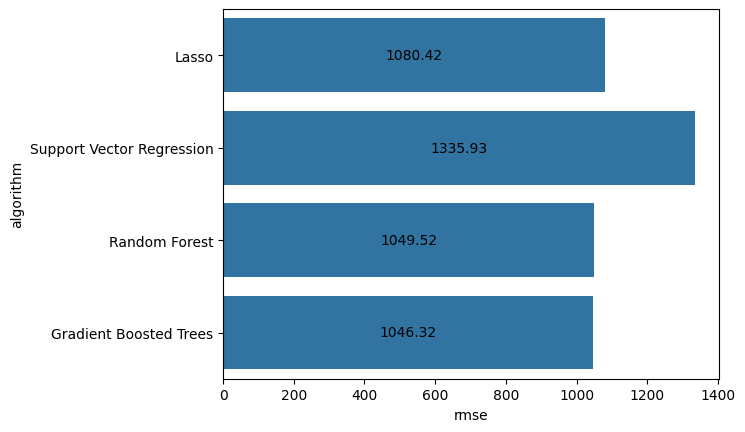

In [50]:
import seaborn as sns
import  matplotlib.pyplot as plt

ax = sns.barplot(modeling_results, y="algorithm", x="rmse")

# Add values to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Display the plot
plt.show()

Result summary:
- GBR model was the "best" model (lowest RMSE).
- However, besides SVR, all models had comparable performance. RMSEs between Lasso, RFR, & GBR were all within 40 seconds of each other, and considering the prediction errors were already > 17 minutes off on average, this doesn't seem like much.
- We'll proceed with RFR: practically, it achieved identical performance with GFR, and it has less of a tendency to overfit since each tree in the forest is built independently. Additionally, the weak correlations (r < 0.2) we saw between the features & delivery duration in our EDA may suggest that the nature of the relationship between the features & target is probably best described in a non-linear fashion.

Write out hyperparameter-tuned GBR model artifact.

In [52]:
import joblib  # Use joblib for efficient model serialization

# Save the best model
best_algorithm = modeling_results.sort_values(by='rmse', ascending=True)['algorithm'].iloc[0]

best_grid_search = None
match best_algorithm:
    case best_algorithm if best_algorithm == 'Lasso':
        best_grid_search = lasso_search_cv
    case best_algorithm if best_algorithm == 'Support Vector Regression':
        best_grid_search = svr_search_cv
    case best_algorithm if best_algorithm == 'Random Forest':
        best_grid_search = rfr_search_cv
    case _:
        best_grid_search = gbr_search_cv

joblib.dump(best_grid_search.best_estimator_, '../models/best_model.pkl')
print("Best model saved to 'best_model.pkl'")

Best model saved to 'best_model.pkl'


Sources:
- Creating custom data transformers:
    - https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html#sphx-glr-auto-examples-compose-plot-column-transformer-py
    - https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- Pipeline:
    - https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- Model scoring:
    - https://scikit-learn.org/1.6/modules/model_evaluation.html#scoring-parameter
    - https://datascience.stackexchange.com/questions/93531/neg-mean-squared-error-in-cross-val-score
- Hyperparameter tuning
    - https://scikit-learn.org/1.6/modules/grid_search.html#grid-search
    - https://www.kaggle.com/code/kenjee/exhaustive-regression-parameter-tuning#ML-Algorithms---Regression-Example
    - https://www.reddit.com/r/datascience/comments/mwl2zj/do_you_often_find_hyperparam_tuning_does_very/
    - https://www.linkedin.com/advice/3/when-should-you-stop-tuning-your-hyperparameters-8j9pf#:~:text=Hyperparameter%20tuning%20is%20essential%20for,you're%20willing%20to%20spend.
